In [6]:
from models.vae import create_VAE
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import h5py

# Modelos pre-entrenados

Si bien se pueden utilizar modelo pre entrenados, no encontramos ningún modelo del mismo dominio(imágenes médicas) público. Por esta razón, entrenaremos un variational auto encoder que servirá como modelo preentrenado para nuestro conditional variational auto encoder. Para este modelo preentrenado utilizamos aproximadamente 7k imágenes médicas.

# Modelos
    Llamaremos a nuestro modelo variational autoencoder preentrenado JDM-XX (Johan, Daniel, Melissa).



La arquitectura general de nuestro Variational Autoencoder es inspirada por el famoso modelo VGG-XX (XX hace referencia al número de capas/bloques). En particular, para el Encoder se utilizaron XX-3 bloques convolucionales (cada uno compuesto de capa convolucional, función de activation LeakyRelu y batch normalization) y 3 capas completamente conectadas. Adicionalmente hay 2 capas extras que se usan para calcular el promedio de Z y el log var de Z. Para el decoder la arquitectura es simétrica. La nomenclatura que usaremos será JDM-XX para referirnos al número de bloques que usamos en cada componente(encoder y decoder) como XX-3 siendo bloques convolucionales y 3 capas completamente conectadas.

Además, se utilizaron 2 variantes distintas de vector latente (256 y 512), teniendo así los siguientes modelos preentrenados:

- JDM-13 con vector latente de tamaño 256 y otro de 512
- JDM-16 con vector latente de tamaño 256 y otro de 512
- JDM-19 con vector latente de tamaño 256 y otro de 512

Se entrenará cada modelo por 400 épocas.

In [2]:
input_img_shape = (128, 128, 1)

JDM13_256 = create_VAE(input_img_shape, latent_dim = 256,  n_blocks=13)
JDM13_512 = create_VAE(input_img_shape, latent_dim = 512,  n_blocks=13)

JDM16_256 = create_VAE(input_img_shape, latent_dim = 256,  n_blocks=16)
JDM16_512 = create_VAE(input_img_shape, latent_dim = 512,  n_blocks=16) 

JDM19_256 = create_VAE(input_img_shape, latent_dim = 256,  n_blocks=19)
JDM19_512 = create_VAE(input_img_shape, latent_dim = 512,  n_blocks=19)

2023-07-26 14:32:21.341701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 14:32:21.344506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 14:32:21.344606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Datos

In [3]:
with h5py.File("data/data_128_7k.h5", "r") as f:
    imgs = np.array(f["imgs"])
    labels = np.array(f["labels"])
print("Dimensión de imágenes:", imgs.shape)
print("Dimensión de labels:", labels.shape)

Dimensión de imágenes: (7023, 128, 128, 1)
Dimensión de labels: (7023, 4)


# Entrenamiento

Tardó 12 horas en entrenar todos los modelos (GPU NVIDIA RTX 3090)

In [4]:
path = "models/JDM_weights/"

filenames = ["JDM-13_256_best", "JDM-13_512_best", 
             "JDM-16_256_best", "JDM-16_512_best",
             "JDM-19_256_best", "JDM-19_512_best"]
models = [JDM13_256, JDM13_512, JDM16_256, JDM16_512, JDM19_256, JDM19_512]

checkpoints = {filename: ModelCheckpoint(filepath=f"{path}/{filename}.h5",
                                         save_weights_only=True,
                                         monitor="loss",
                                         mode="min",
histories = {}
for model,filename in zip(models, filenames):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    history = model.fit(imgs, epochs=400, batch_size=64, callbacks=[checkpoints[filename]])
    histories[filename] = history


Epoch 1/400


2023-07-26 14:32:26.394564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-26 14:32:26.926296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-26 14:32:28.518916: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f379e2803b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 14:32:28.518940: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-26 14:32:28.521649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-26 14:32:28.592951: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

110/110 [==============================] - 26s 142ms/step - loss: 8917.3871 - reconstruction_loss: 7710.2529 - kl_loss: 8.4723
Epoch 2/400
110/110 [==============================] - 13s 114ms/step - loss: 6748.5438 - reconstruction_loss: 6725.0972 - kl_loss: 14.2171
Epoch 3/400
110/110 [==============================] - 13s 114ms/step - loss: 6713.3036 - reconstruction_loss: 6714.7954 - kl_loss: 13.3408
Epoch 4/400
110/110 [==============================] - 13s 114ms/step - loss: 6702.9523 - reconstruction_loss: 6682.7485 - kl_loss: 16.6245
Epoch 5/400
110/110 [==============================] - 13s 114ms/step - loss: 6649.5359 - reconstruction_loss: 6608.7251 - kl_loss: 21.4138
Epoch 6/400
110/110 [==============================] - 13s 115ms/step - loss: 6617.3458 - reconstruction_loss: 6583.8862 - kl_loss: 21.4681
Epoch 7/400
110/110 [==============================] - 13s 115ms/step - loss: 6601.8287 - reconstruction_loss: 6545.8765 - kl_loss: 22.7097
Epoch 8/400
110/110 [============

110/110 [==============================] - 13s 115ms/step - loss: 6042.0898 - reconstruction_loss: 6021.8735 - kl_loss: 45.7584
Epoch 60/400
110/110 [==============================] - 13s 115ms/step - loss: 6057.5867 - reconstruction_loss: 6021.8335 - kl_loss: 45.1403
Epoch 61/400
110/110 [==============================] - 13s 115ms/step - loss: 6085.6452 - reconstruction_loss: 6013.3896 - kl_loss: 45.0115
Epoch 62/400
110/110 [==============================] - 13s 115ms/step - loss: 6046.8034 - reconstruction_loss: 6008.7983 - kl_loss: 44.9048
Epoch 63/400
110/110 [==============================] - 13s 115ms/step - loss: 6061.9107 - reconstruction_loss: 6006.5840 - kl_loss: 44.5638
Epoch 64/400
110/110 [==============================] - 13s 115ms/step - loss: 6040.2931 - reconstruction_loss: 5999.2451 - kl_loss: 44.5528
Epoch 65/400
110/110 [==============================] - 13s 116ms/step - loss: 6019.2940 - reconstruction_loss: 5998.1431 - kl_loss: 44.6319
Epoch 66/400
110/110 [====

110/110 [==============================] - 13s 115ms/step - loss: 5899.0800 - reconstruction_loss: 5871.5894 - kl_loss: 38.6482
Epoch 118/400
110/110 [==============================] - 12s 113ms/step - loss: 5910.3183 - reconstruction_loss: 5874.8267 - kl_loss: 38.4341
Epoch 119/400
110/110 [==============================] - 12s 113ms/step - loss: 5920.7968 - reconstruction_loss: 5873.0039 - kl_loss: 38.4679
Epoch 120/400
110/110 [==============================] - 13s 115ms/step - loss: 5919.7930 - reconstruction_loss: 5866.3833 - kl_loss: 38.3737
Epoch 121/400
110/110 [==============================] - 12s 113ms/step - loss: 5906.8381 - reconstruction_loss: 5866.4683 - kl_loss: 38.2907
Epoch 122/400
110/110 [==============================] - 13s 115ms/step - loss: 5874.2792 - reconstruction_loss: 5862.8252 - kl_loss: 38.0793
Epoch 123/400
110/110 [==============================] - 12s 113ms/step - loss: 5899.4898 - reconstruction_loss: 5865.5591 - kl_loss: 38.1996
Epoch 124/400
110/11

110/110 [==============================] - 12s 113ms/step - loss: 5822.3416 - reconstruction_loss: 5804.2461 - kl_loss: 34.0751
Epoch 175/400
110/110 [==============================] - 12s 113ms/step - loss: 5836.2220 - reconstruction_loss: 5804.4727 - kl_loss: 33.9811
Epoch 176/400
110/110 [==============================] - 13s 115ms/step - loss: 5862.8114 - reconstruction_loss: 5801.3027 - kl_loss: 33.8188
Epoch 177/400
110/110 [==============================] - 13s 115ms/step - loss: 5813.0917 - reconstruction_loss: 5799.4736 - kl_loss: 33.8348
Epoch 178/400
110/110 [==============================] - 13s 115ms/step - loss: 5828.6357 - reconstruction_loss: 5798.5923 - kl_loss: 33.6457
Epoch 179/400
110/110 [==============================] - 12s 113ms/step - loss: 5855.5763 - reconstruction_loss: 5799.5620 - kl_loss: 33.6367
Epoch 180/400
110/110 [==============================] - 12s 113ms/step - loss: 5843.5220 - reconstruction_loss: 5801.7544 - kl_loss: 33.5314
Epoch 181/400
110/11

110/110 [==============================] - 12s 113ms/step - loss: 5817.1593 - reconstruction_loss: 5762.4272 - kl_loss: 31.6385
Epoch 232/400
110/110 [==============================] - 13s 115ms/step - loss: 5809.3733 - reconstruction_loss: 5759.8345 - kl_loss: 31.6644
Epoch 233/400
110/110 [==============================] - 12s 113ms/step - loss: 5768.4356 - reconstruction_loss: 5763.9326 - kl_loss: 31.7042
Epoch 234/400
110/110 [==============================] - 12s 113ms/step - loss: 5769.5037 - reconstruction_loss: 5762.3926 - kl_loss: 31.4790
Epoch 235/400
110/110 [==============================] - 13s 115ms/step - loss: 5791.4733 - reconstruction_loss: 5759.2715 - kl_loss: 31.4839
Epoch 236/400
110/110 [==============================] - 12s 113ms/step - loss: 5785.8524 - reconstruction_loss: 5759.4292 - kl_loss: 31.3645
Epoch 237/400
110/110 [==============================] - 12s 113ms/step - loss: 5803.3958 - reconstruction_loss: 5761.0811 - kl_loss: 31.4704
Epoch 238/400
110/11

110/110 [==============================] - 13s 116ms/step - loss: 5759.0039 - reconstruction_loss: 5735.1880 - kl_loss: 30.3347
Epoch 289/400
110/110 [==============================] - 12s 113ms/step - loss: 5775.1068 - reconstruction_loss: 5737.8945 - kl_loss: 30.4429
Epoch 290/400
110/110 [==============================] - 13s 115ms/step - loss: 5745.1944 - reconstruction_loss: 5732.1074 - kl_loss: 30.3799
Epoch 291/400
110/110 [==============================] - 12s 113ms/step - loss: 5782.9878 - reconstruction_loss: 5737.0903 - kl_loss: 30.3330
Epoch 292/400
110/110 [==============================] - 12s 113ms/step - loss: 5750.6081 - reconstruction_loss: 5734.7988 - kl_loss: 30.3298
Epoch 293/400
110/110 [==============================] - 12s 113ms/step - loss: 5728.8909 - reconstruction_loss: 5732.7905 - kl_loss: 30.3628
Epoch 294/400
110/110 [==============================] - 12s 114ms/step - loss: 5759.8720 - reconstruction_loss: 5734.6211 - kl_loss: 30.3171
Epoch 295/400
110/11

110/110 [==============================] - 12s 113ms/step - loss: 5743.8773 - reconstruction_loss: 5716.2915 - kl_loss: 29.6182
Epoch 346/400
110/110 [==============================] - 12s 113ms/step - loss: 5794.6347 - reconstruction_loss: 5717.1084 - kl_loss: 29.6582
Epoch 347/400
110/110 [==============================] - 12s 113ms/step - loss: 5709.9203 - reconstruction_loss: 5717.6577 - kl_loss: 29.7031
Epoch 348/400
110/110 [==============================] - 13s 115ms/step - loss: 5757.3206 - reconstruction_loss: 5714.4521 - kl_loss: 29.6629
Epoch 349/400
110/110 [==============================] - 13s 115ms/step - loss: 5758.6135 - reconstruction_loss: 5713.9863 - kl_loss: 29.6999
Epoch 350/400
110/110 [==============================] - 13s 115ms/step - loss: 5754.4847 - reconstruction_loss: 5713.3755 - kl_loss: 29.6369
Epoch 351/400
110/110 [==============================] - 13s 115ms/step - loss: 5751.0277 - reconstruction_loss: 5713.2920 - kl_loss: 29.6436
Epoch 352/400
110/11

110/110 [==============================] - 13s 115ms/step - loss: 6914.8008 - reconstruction_loss: 6784.1289 - kl_loss: 21.0915
Epoch 3/400
110/110 [==============================] - 13s 115ms/step - loss: 6763.8005 - reconstruction_loss: 6715.5078 - kl_loss: 13.9328
Epoch 4/400
110/110 [==============================] - 13s 115ms/step - loss: 6728.4829 - reconstruction_loss: 6708.3794 - kl_loss: 13.6665
Epoch 5/400
110/110 [==============================] - 13s 115ms/step - loss: 6706.7675 - reconstruction_loss: 6683.4512 - kl_loss: 17.6249
Epoch 6/400
110/110 [==============================] - 13s 115ms/step - loss: 6630.3648 - reconstruction_loss: 6613.2539 - kl_loss: 22.4280
Epoch 7/400
110/110 [==============================] - 13s 115ms/step - loss: 6635.0730 - reconstruction_loss: 6589.5820 - kl_loss: 22.0631
Epoch 8/400
110/110 [==============================] - 13s 115ms/step - loss: 6598.0072 - reconstruction_loss: 6565.6050 - kl_loss: 22.6082
Epoch 9/400
110/110 [===========

110/110 [==============================] - 13s 115ms/step - loss: 6133.9400 - reconstruction_loss: 6062.3550 - kl_loss: 49.9628
Epoch 61/400
110/110 [==============================] - 13s 115ms/step - loss: 6141.6992 - reconstruction_loss: 6056.7529 - kl_loss: 50.4287
Epoch 62/400
110/110 [==============================] - 13s 115ms/step - loss: 6116.7007 - reconstruction_loss: 6047.2070 - kl_loss: 50.3307
Epoch 63/400
110/110 [==============================] - 13s 115ms/step - loss: 6101.3557 - reconstruction_loss: 6043.4204 - kl_loss: 50.2054
Epoch 64/400
110/110 [==============================] - 13s 115ms/step - loss: 6093.9536 - reconstruction_loss: 6041.1875 - kl_loss: 50.0274
Epoch 65/400
110/110 [==============================] - 13s 116ms/step - loss: 6102.5019 - reconstruction_loss: 6030.2383 - kl_loss: 50.1723
Epoch 66/400
110/110 [==============================] - 13s 115ms/step - loss: 6100.4853 - reconstruction_loss: 6028.5166 - kl_loss: 50.2742
Epoch 67/400
110/110 [====

110/110 [==============================] - 13s 115ms/step - loss: 5937.8112 - reconstruction_loss: 5885.5127 - kl_loss: 42.9445
Epoch 119/400
110/110 [==============================] - 13s 115ms/step - loss: 5922.7527 - reconstruction_loss: 5884.6460 - kl_loss: 42.6334
Epoch 120/400
110/110 [==============================] - 13s 115ms/step - loss: 5904.7548 - reconstruction_loss: 5880.2334 - kl_loss: 42.5014
Epoch 121/400
110/110 [==============================] - 12s 113ms/step - loss: 5933.9168 - reconstruction_loss: 5880.9941 - kl_loss: 42.4310
Epoch 122/400
110/110 [==============================] - 13s 115ms/step - loss: 5925.6159 - reconstruction_loss: 5877.5879 - kl_loss: 42.1442
Epoch 123/400
110/110 [==============================] - 13s 116ms/step - loss: 5915.9450 - reconstruction_loss: 5876.5337 - kl_loss: 42.0851
Epoch 124/400
110/110 [==============================] - 13s 115ms/step - loss: 5923.1912 - reconstruction_loss: 5873.7842 - kl_loss: 41.6758
Epoch 125/400
110/11

110/110 [==============================] - 12s 113ms/step - loss: 5848.4794 - reconstruction_loss: 5807.6479 - kl_loss: 37.9486
Epoch 176/400
110/110 [==============================] - 12s 113ms/step - loss: 5839.3885 - reconstruction_loss: 5806.7891 - kl_loss: 38.0388
Epoch 177/400
110/110 [==============================] - 12s 113ms/step - loss: 5812.3263 - reconstruction_loss: 5808.1577 - kl_loss: 37.9413
Epoch 178/400
110/110 [==============================] - 13s 116ms/step - loss: 5828.4624 - reconstruction_loss: 5806.2158 - kl_loss: 37.7360
Epoch 179/400
110/110 [==============================] - 13s 116ms/step - loss: 5855.8877 - reconstruction_loss: 5805.3203 - kl_loss: 37.5629
Epoch 180/400
110/110 [==============================] - 13s 115ms/step - loss: 5836.8870 - reconstruction_loss: 5802.5239 - kl_loss: 37.5677
Epoch 181/400
110/110 [==============================] - 12s 113ms/step - loss: 5832.4706 - reconstruction_loss: 5804.5518 - kl_loss: 37.4595
Epoch 182/400
110/11

110/110 [==============================] - 12s 113ms/step - loss: 5817.4131 - reconstruction_loss: 5766.3955 - kl_loss: 35.5908
Epoch 233/400
110/110 [==============================] - 13s 115ms/step - loss: 5813.7951 - reconstruction_loss: 5762.3208 - kl_loss: 35.3161
Epoch 234/400
110/110 [==============================] - 12s 113ms/step - loss: 5785.5811 - reconstruction_loss: 5762.6943 - kl_loss: 35.5373
Epoch 235/400
110/110 [==============================] - 13s 115ms/step - loss: 5815.4298 - reconstruction_loss: 5760.9058 - kl_loss: 35.3549
Epoch 236/400
110/110 [==============================] - 13s 115ms/step - loss: 5790.9516 - reconstruction_loss: 5760.5161 - kl_loss: 35.4463
Epoch 237/400
110/110 [==============================] - 12s 113ms/step - loss: 5806.2037 - reconstruction_loss: 5765.0659 - kl_loss: 35.4011
Epoch 238/400
110/110 [==============================] - 13s 115ms/step - loss: 5786.6077 - reconstruction_loss: 5760.2993 - kl_loss: 35.3396
Epoch 239/400
110/11

110/110 [==============================] - 12s 113ms/step - loss: 5773.9558 - reconstruction_loss: 5735.8701 - kl_loss: 34.2019
Epoch 290/400
110/110 [==============================] - 13s 116ms/step - loss: 5791.0722 - reconstruction_loss: 5734.2021 - kl_loss: 34.1050
Epoch 291/400
110/110 [==============================] - 12s 113ms/step - loss: 5783.9656 - reconstruction_loss: 5736.1641 - kl_loss: 34.1152
Epoch 292/400
110/110 [==============================] - 12s 113ms/step - loss: 5764.2971 - reconstruction_loss: 5735.2715 - kl_loss: 34.0098
Epoch 293/400
110/110 [==============================] - 12s 113ms/step - loss: 5734.7379 - reconstruction_loss: 5734.4473 - kl_loss: 34.0226
Epoch 294/400
110/110 [==============================] - 12s 113ms/step - loss: 5750.8024 - reconstruction_loss: 5734.2041 - kl_loss: 34.1183
Epoch 295/400
110/110 [==============================] - 13s 115ms/step - loss: 5765.6995 - reconstruction_loss: 5733.9521 - kl_loss: 34.0488
Epoch 296/400
110/11

110/110 [==============================] - 12s 113ms/step - loss: 5731.5176 - reconstruction_loss: 5716.0923 - kl_loss: 33.0874
Epoch 347/400
110/110 [==============================] - 13s 115ms/step - loss: 5750.1289 - reconstruction_loss: 5715.5210 - kl_loss: 33.0857
Epoch 348/400
110/110 [==============================] - 12s 113ms/step - loss: 5729.0934 - reconstruction_loss: 5715.7749 - kl_loss: 33.0187
Epoch 349/400
110/110 [==============================] - 13s 115ms/step - loss: 5759.2430 - reconstruction_loss: 5714.6367 - kl_loss: 32.8704
Epoch 350/400
110/110 [==============================] - 12s 113ms/step - loss: 5716.3475 - reconstruction_loss: 5716.5801 - kl_loss: 32.9961
Epoch 351/400
110/110 [==============================] - 12s 113ms/step - loss: 5755.4468 - reconstruction_loss: 5716.1812 - kl_loss: 33.0143
Epoch 352/400
110/110 [==============================] - 12s 113ms/step - loss: 5751.7245 - reconstruction_loss: 5716.0161 - kl_loss: 33.0104
Epoch 353/400
110/11

110/110 [==============================] - 15s 137ms/step - loss: 6765.6109 - reconstruction_loss: 6736.0430 - kl_loss: 16.0003
Epoch 4/400
110/110 [==============================] - 15s 137ms/step - loss: 6742.0835 - reconstruction_loss: 6719.7236 - kl_loss: 13.2922
Epoch 5/400
110/110 [==============================] - 15s 135ms/step - loss: 6739.7903 - reconstruction_loss: 6721.3618 - kl_loss: 13.1763
Epoch 6/400
110/110 [==============================] - 15s 138ms/step - loss: 6753.9818 - reconstruction_loss: 6715.9458 - kl_loss: 13.3803
Epoch 7/400
110/110 [==============================] - 15s 137ms/step - loss: 6717.1083 - reconstruction_loss: 6710.2407 - kl_loss: 13.4354
Epoch 8/400
110/110 [==============================] - 15s 137ms/step - loss: 6739.2958 - reconstruction_loss: 6701.2842 - kl_loss: 13.6121
Epoch 9/400
110/110 [==============================] - 15s 137ms/step - loss: 6736.0218 - reconstruction_loss: 6666.5000 - kl_loss: 18.2982
Epoch 10/400
110/110 [==========

110/110 [==============================] - 15s 137ms/step - loss: 6154.2467 - reconstruction_loss: 6105.3545 - kl_loss: 39.5835
Epoch 62/400
110/110 [==============================] - 15s 137ms/step - loss: 6151.4452 - reconstruction_loss: 6102.5098 - kl_loss: 39.5801
Epoch 63/400
110/110 [==============================] - 15s 137ms/step - loss: 6124.2759 - reconstruction_loss: 6098.0615 - kl_loss: 40.0975
Epoch 64/400
110/110 [==============================] - 15s 137ms/step - loss: 6089.4887 - reconstruction_loss: 6088.0039 - kl_loss: 40.1583
Epoch 65/400
110/110 [==============================] - 15s 137ms/step - loss: 6105.5941 - reconstruction_loss: 6080.7354 - kl_loss: 40.0348
Epoch 66/400
110/110 [==============================] - 15s 135ms/step - loss: 6131.5509 - reconstruction_loss: 6082.5591 - kl_loss: 40.1744
Epoch 67/400
110/110 [==============================] - 15s 137ms/step - loss: 6142.4959 - reconstruction_loss: 6076.0342 - kl_loss: 40.0853
Epoch 68/400
110/110 [====

110/110 [==============================] - 15s 137ms/step - loss: 5982.2000 - reconstruction_loss: 5928.8252 - kl_loss: 35.5913
Epoch 120/400
110/110 [==============================] - 15s 137ms/step - loss: 5963.7356 - reconstruction_loss: 5924.1704 - kl_loss: 35.4839
Epoch 121/400
110/110 [==============================] - 15s 135ms/step - loss: 5933.6258 - reconstruction_loss: 5926.1631 - kl_loss: 35.3400
Epoch 122/400
110/110 [==============================] - 15s 137ms/step - loss: 5953.6204 - reconstruction_loss: 5922.4580 - kl_loss: 35.2277
Epoch 123/400
110/110 [==============================] - 15s 137ms/step - loss: 5976.0324 - reconstruction_loss: 5919.1494 - kl_loss: 35.2410
Epoch 124/400
110/110 [==============================] - 15s 135ms/step - loss: 5960.6973 - reconstruction_loss: 5920.0806 - kl_loss: 35.2932
Epoch 125/400
110/110 [==============================] - 15s 137ms/step - loss: 5934.1773 - reconstruction_loss: 5917.4609 - kl_loss: 35.2664
Epoch 126/400
110/11

110/110 [==============================] - 15s 137ms/step - loss: 5854.8982 - reconstruction_loss: 5847.2603 - kl_loss: 33.3412
Epoch 177/400
110/110 [==============================] - 15s 135ms/step - loss: 5901.1842 - reconstruction_loss: 5849.9136 - kl_loss: 33.4103
Epoch 178/400
110/110 [==============================] - 15s 137ms/step - loss: 5882.7135 - reconstruction_loss: 5841.4702 - kl_loss: 33.3002
Epoch 179/400
110/110 [==============================] - 15s 137ms/step - loss: 5872.4178 - reconstruction_loss: 5840.8799 - kl_loss: 33.1385
Epoch 180/400
110/110 [==============================] - 15s 137ms/step - loss: 5844.6628 - reconstruction_loss: 5839.8779 - kl_loss: 33.2796
Epoch 181/400
110/110 [==============================] - 15s 135ms/step - loss: 5889.9845 - reconstruction_loss: 5843.7075 - kl_loss: 33.2380
Epoch 182/400
110/110 [==============================] - 15s 137ms/step - loss: 5882.8488 - reconstruction_loss: 5838.8989 - kl_loss: 32.9857
Epoch 183/400
110/11

110/110 [==============================] - 15s 135ms/step - loss: 5794.6089 - reconstruction_loss: 5800.3633 - kl_loss: 31.7449
Epoch 234/400
110/110 [==============================] - 15s 137ms/step - loss: 5846.8872 - reconstruction_loss: 5799.4800 - kl_loss: 31.6679
Epoch 235/400
110/110 [==============================] - 15s 137ms/step - loss: 5854.2830 - reconstruction_loss: 5796.3516 - kl_loss: 31.5343
Epoch 236/400
110/110 [==============================] - 15s 135ms/step - loss: 5810.9527 - reconstruction_loss: 5797.0210 - kl_loss: 31.6827
Epoch 237/400
110/110 [==============================] - 15s 137ms/step - loss: 5823.2861 - reconstruction_loss: 5795.8818 - kl_loss: 31.4699
Epoch 238/400
110/110 [==============================] - 15s 135ms/step - loss: 5847.8294 - reconstruction_loss: 5798.7007 - kl_loss: 31.4315
Epoch 239/400
110/110 [==============================] - 15s 135ms/step - loss: 5814.9510 - reconstruction_loss: 5796.7603 - kl_loss: 31.5432
Epoch 240/400
110/11

110/110 [==============================] - 15s 137ms/step - loss: 5779.1714 - reconstruction_loss: 5767.3242 - kl_loss: 29.2890
Epoch 291/400
110/110 [==============================] - 15s 135ms/step - loss: 5787.2681 - reconstruction_loss: 5771.4917 - kl_loss: 29.2713
Epoch 292/400
110/110 [==============================] - 15s 135ms/step - loss: 5831.7733 - reconstruction_loss: 5770.4434 - kl_loss: 29.4171
Epoch 293/400
110/110 [==============================] - 15s 138ms/step - loss: 5775.6591 - reconstruction_loss: 5765.5894 - kl_loss: 29.2798
Epoch 294/400
110/110 [==============================] - 15s 134ms/step - loss: 5798.3232 - reconstruction_loss: 5767.2192 - kl_loss: 29.1854
Epoch 295/400
110/110 [==============================] - 15s 134ms/step - loss: 5797.9285 - reconstruction_loss: 5769.4263 - kl_loss: 29.2651
Epoch 296/400
110/110 [==============================] - 15s 137ms/step - loss: 5818.1700 - reconstruction_loss: 5764.2632 - kl_loss: 29.1953
Epoch 297/400
110/11

110/110 [==============================] - 15s 135ms/step - loss: 5818.9937 - reconstruction_loss: 5749.8359 - kl_loss: 27.7666
Epoch 348/400
110/110 [==============================] - 15s 135ms/step - loss: 5772.9204 - reconstruction_loss: 5749.7993 - kl_loss: 27.5989
Epoch 349/400
110/110 [==============================] - 15s 137ms/step - loss: 5765.2770 - reconstruction_loss: 5746.7603 - kl_loss: 27.5754
Epoch 350/400
110/110 [==============================] - 15s 139ms/step - loss: 5743.3601 - reconstruction_loss: 5746.2373 - kl_loss: 27.5165
Epoch 351/400
110/110 [==============================] - 15s 137ms/step - loss: 5760.2262 - reconstruction_loss: 5748.1523 - kl_loss: 27.4443
Epoch 352/400
110/110 [==============================] - 15s 136ms/step - loss: 5784.0638 - reconstruction_loss: 5746.3403 - kl_loss: 27.5146
Epoch 353/400
110/110 [==============================] - 15s 138ms/step - loss: 5764.0446 - reconstruction_loss: 5745.1724 - kl_loss: 27.2928
Epoch 354/400
110/11

110/110 [==============================] - 15s 140ms/step - loss: 6745.9651 - reconstruction_loss: 6720.7920 - kl_loss: 13.5823
Epoch 5/400
110/110 [==============================] - 15s 138ms/step - loss: 6748.7610 - reconstruction_loss: 6713.6411 - kl_loss: 13.7175
Epoch 6/400
110/110 [==============================] - 15s 137ms/step - loss: 6763.4418 - reconstruction_loss: 6703.6665 - kl_loss: 14.3593
Epoch 7/400
110/110 [==============================] - 15s 137ms/step - loss: 6697.1712 - reconstruction_loss: 6656.5786 - kl_loss: 20.3641
Epoch 8/400
110/110 [==============================] - 15s 138ms/step - loss: 6654.4021 - reconstruction_loss: 6610.7056 - kl_loss: 21.3726
Epoch 9/400
110/110 [==============================] - 15s 138ms/step - loss: 6618.8911 - reconstruction_loss: 6580.3257 - kl_loss: 21.9390
Epoch 10/400
110/110 [==============================] - 15s 137ms/step - loss: 6580.4201 - reconstruction_loss: 6550.9390 - kl_loss: 23.9397
Epoch 11/400
110/110 [=========

110/110 [==============================] - 15s 135ms/step - loss: 6162.5807 - reconstruction_loss: 6097.3481 - kl_loss: 45.2032
Epoch 63/400
110/110 [==============================] - 15s 137ms/step - loss: 6133.3190 - reconstruction_loss: 6089.5903 - kl_loss: 45.4903
Epoch 64/400
110/110 [==============================] - 15s 137ms/step - loss: 6155.0544 - reconstruction_loss: 6089.7212 - kl_loss: 45.2876
Epoch 65/400
110/110 [==============================] - 15s 137ms/step - loss: 6129.0735 - reconstruction_loss: 6083.9736 - kl_loss: 45.0416
Epoch 66/400
110/110 [==============================] - 15s 137ms/step - loss: 6115.9547 - reconstruction_loss: 6080.3882 - kl_loss: 45.2499
Epoch 67/400
110/110 [==============================] - 15s 137ms/step - loss: 6131.2263 - reconstruction_loss: 6076.5137 - kl_loss: 45.4258
Epoch 68/400
110/110 [==============================] - 15s 137ms/step - loss: 6113.1423 - reconstruction_loss: 6071.2905 - kl_loss: 45.3539
Epoch 69/400
110/110 [====

110/110 [==============================] - 15s 137ms/step - loss: 5952.4080 - reconstruction_loss: 5926.3228 - kl_loss: 43.0379
Epoch 121/400
110/110 [==============================] - 15s 137ms/step - loss: 5985.5262 - reconstruction_loss: 5925.1987 - kl_loss: 42.9763
Epoch 122/400
110/110 [==============================] - 15s 137ms/step - loss: 5968.1555 - reconstruction_loss: 5920.3555 - kl_loss: 42.9215
Epoch 123/400
110/110 [==============================] - 15s 135ms/step - loss: 5999.3859 - reconstruction_loss: 5922.0459 - kl_loss: 42.8478
Epoch 124/400
110/110 [==============================] - 15s 135ms/step - loss: 5942.1189 - reconstruction_loss: 5921.6489 - kl_loss: 42.7674
Epoch 125/400
110/110 [==============================] - 15s 137ms/step - loss: 5996.0434 - reconstruction_loss: 5918.3394 - kl_loss: 42.9583
Epoch 126/400
110/110 [==============================] - 15s 135ms/step - loss: 5961.4236 - reconstruction_loss: 5919.3130 - kl_loss: 42.9086
Epoch 127/400
110/11

110/110 [==============================] - 15s 135ms/step - loss: 5883.3823 - reconstruction_loss: 5846.1772 - kl_loss: 40.1971
Epoch 178/400
110/110 [==============================] - 15s 135ms/step - loss: 5871.5241 - reconstruction_loss: 5844.7583 - kl_loss: 40.1057
Epoch 179/400
110/110 [==============================] - 15s 137ms/step - loss: 5865.1456 - reconstruction_loss: 5842.9873 - kl_loss: 39.9772
Epoch 180/400
110/110 [==============================] - 15s 137ms/step - loss: 5856.3686 - reconstruction_loss: 5839.4536 - kl_loss: 39.9527
Epoch 181/400
110/110 [==============================] - 15s 135ms/step - loss: 5927.4477 - reconstruction_loss: 5841.3325 - kl_loss: 40.0565
Epoch 182/400
110/110 [==============================] - 15s 135ms/step - loss: 5893.2155 - reconstruction_loss: 5844.8467 - kl_loss: 39.8981
Epoch 183/400
110/110 [==============================] - 15s 137ms/step - loss: 5888.3278 - reconstruction_loss: 5837.4507 - kl_loss: 39.8034
Epoch 184/400
110/11

110/110 [==============================] - 15s 137ms/step - loss: 5818.1022 - reconstruction_loss: 5795.3267 - kl_loss: 37.0562
Epoch 235/400
110/110 [==============================] - 15s 135ms/step - loss: 5825.2389 - reconstruction_loss: 5795.3062 - kl_loss: 37.0982
Epoch 236/400
110/110 [==============================] - 15s 138ms/step - loss: 5809.7553 - reconstruction_loss: 5794.3765 - kl_loss: 36.9118
Epoch 237/400
110/110 [==============================] - 15s 135ms/step - loss: 5819.9722 - reconstruction_loss: 5795.7876 - kl_loss: 36.9805
Epoch 238/400
110/110 [==============================] - 15s 137ms/step - loss: 5850.2103 - reconstruction_loss: 5791.9106 - kl_loss: 37.1142
Epoch 239/400
110/110 [==============================] - 15s 137ms/step - loss: 5815.5994 - reconstruction_loss: 5791.6113 - kl_loss: 36.8940
Epoch 240/400
110/110 [==============================] - 15s 135ms/step - loss: 5849.4241 - reconstruction_loss: 5792.5732 - kl_loss: 36.7446
Epoch 241/400
110/11

110/110 [==============================] - 15s 135ms/step - loss: 5800.8722 - reconstruction_loss: 5767.3521 - kl_loss: 34.8669
Epoch 292/400
110/110 [==============================] - 15s 135ms/step - loss: 5807.2723 - reconstruction_loss: 5767.6836 - kl_loss: 35.0598
Epoch 293/400
110/110 [==============================] - 15s 135ms/step - loss: 5803.0612 - reconstruction_loss: 5765.8184 - kl_loss: 35.0396
Epoch 294/400
110/110 [==============================] - 15s 135ms/step - loss: 5797.9505 - reconstruction_loss: 5767.3120 - kl_loss: 34.9840
Epoch 295/400
110/110 [==============================] - 15s 138ms/step - loss: 5785.0564 - reconstruction_loss: 5762.8774 - kl_loss: 34.8263
Epoch 296/400
110/110 [==============================] - 15s 135ms/step - loss: 5796.2082 - reconstruction_loss: 5762.9580 - kl_loss: 34.8564
Epoch 297/400
110/110 [==============================] - 15s 137ms/step - loss: 5789.2724 - reconstruction_loss: 5762.4146 - kl_loss: 34.8395
Epoch 298/400
110/11

110/110 [==============================] - 15s 135ms/step - loss: 5792.9264 - reconstruction_loss: 5744.9399 - kl_loss: 33.7447
Epoch 349/400
110/110 [==============================] - 15s 137ms/step - loss: 5775.1744 - reconstruction_loss: 5743.2095 - kl_loss: 33.7382
Epoch 350/400
110/110 [==============================] - 15s 136ms/step - loss: 5772.7679 - reconstruction_loss: 5744.6792 - kl_loss: 33.7147
Epoch 351/400
110/110 [==============================] - 15s 135ms/step - loss: 5767.2756 - reconstruction_loss: 5744.8569 - kl_loss: 33.6914
Epoch 352/400
110/110 [==============================] - 15s 135ms/step - loss: 5761.1063 - reconstruction_loss: 5743.9204 - kl_loss: 33.8009
Epoch 353/400
110/110 [==============================] - 15s 135ms/step - loss: 5782.1286 - reconstruction_loss: 5745.5347 - kl_loss: 33.6280
Epoch 354/400
110/110 [==============================] - 15s 137ms/step - loss: 5769.0904 - reconstruction_loss: 5742.7217 - kl_loss: 33.6089
Epoch 355/400
110/11

110/110 [==============================] - 19s 176ms/step - loss: 6737.8187 - reconstruction_loss: 6704.4106 - kl_loss: 14.1909
Epoch 6/400
110/110 [==============================] - 19s 176ms/step - loss: 6670.6815 - reconstruction_loss: 6670.5596 - kl_loss: 18.6385
Epoch 7/400
110/110 [==============================] - 19s 176ms/step - loss: 6649.6400 - reconstruction_loss: 6616.2026 - kl_loss: 20.2318
Epoch 8/400
110/110 [==============================] - 19s 176ms/step - loss: 6598.4394 - reconstruction_loss: 6588.4624 - kl_loss: 20.5086
Epoch 9/400
110/110 [==============================] - 19s 176ms/step - loss: 6609.5947 - reconstruction_loss: 6579.5664 - kl_loss: 21.6785
Epoch 10/400
110/110 [==============================] - 19s 176ms/step - loss: 6563.7275 - reconstruction_loss: 6538.5947 - kl_loss: 23.2838
Epoch 11/400
110/110 [==============================] - 19s 176ms/step - loss: 6546.5224 - reconstruction_loss: 6514.6313 - kl_loss: 25.6579
Epoch 12/400
110/110 [========

110/110 [==============================] - 19s 176ms/step - loss: 6072.7159 - reconstruction_loss: 6041.1992 - kl_loss: 33.7635
Epoch 64/400
110/110 [==============================] - 19s 176ms/step - loss: 6048.1199 - reconstruction_loss: 6034.2607 - kl_loss: 33.2752
Epoch 65/400
110/110 [==============================] - 19s 176ms/step - loss: 6062.1037 - reconstruction_loss: 6032.4146 - kl_loss: 33.5971
Epoch 66/400
110/110 [==============================] - 19s 176ms/step - loss: 6065.1124 - reconstruction_loss: 6024.3564 - kl_loss: 33.1633
Epoch 67/400
110/110 [==============================] - 19s 176ms/step - loss: 6034.8851 - reconstruction_loss: 6023.2407 - kl_loss: 33.0949
Epoch 68/400
110/110 [==============================] - 19s 176ms/step - loss: 6050.0463 - reconstruction_loss: 6014.8438 - kl_loss: 33.4553
Epoch 69/400
110/110 [==============================] - 19s 176ms/step - loss: 6046.6666 - reconstruction_loss: 6012.9551 - kl_loss: 33.2665
Epoch 70/400
110/110 [====

110/110 [==============================] - 19s 176ms/step - loss: 5901.5888 - reconstruction_loss: 5856.7485 - kl_loss: 30.6285
Epoch 122/400
110/110 [==============================] - 19s 171ms/step - loss: 5896.8712 - reconstruction_loss: 5866.2144 - kl_loss: 30.7413
Epoch 123/400
110/110 [==============================] - 19s 171ms/step - loss: 5920.4382 - reconstruction_loss: 5862.2114 - kl_loss: 30.7252
Epoch 124/400
110/110 [==============================] - 19s 176ms/step - loss: 5877.7955 - reconstruction_loss: 5850.6768 - kl_loss: 30.6523
Epoch 125/400
110/110 [==============================] - 19s 171ms/step - loss: 5893.9197 - reconstruction_loss: 5855.4248 - kl_loss: 30.5044
Epoch 126/400
110/110 [==============================] - 19s 176ms/step - loss: 5852.0302 - reconstruction_loss: 5846.9927 - kl_loss: 30.3084
Epoch 127/400
110/110 [==============================] - 19s 172ms/step - loss: 5892.9045 - reconstruction_loss: 5848.2764 - kl_loss: 30.5493
Epoch 128/400
110/11

110/110 [==============================] - 19s 176ms/step - loss: 5807.1293 - reconstruction_loss: 5777.8369 - kl_loss: 28.8263
Epoch 179/400
110/110 [==============================] - 19s 171ms/step - loss: 5810.6152 - reconstruction_loss: 5780.5093 - kl_loss: 28.8616
Epoch 180/400
110/110 [==============================] - 19s 172ms/step - loss: 5833.3095 - reconstruction_loss: 5778.0854 - kl_loss: 28.8010
Epoch 181/400
110/110 [==============================] - 19s 176ms/step - loss: 5810.3329 - reconstruction_loss: 5777.0811 - kl_loss: 28.7074
Epoch 182/400
110/110 [==============================] - 19s 171ms/step - loss: 5801.3729 - reconstruction_loss: 5779.8257 - kl_loss: 28.8079
Epoch 183/400
110/110 [==============================] - 19s 171ms/step - loss: 5811.1593 - reconstruction_loss: 5777.8130 - kl_loss: 28.6883
Epoch 184/400
110/110 [==============================] - 19s 172ms/step - loss: 5794.9425 - reconstruction_loss: 5783.3452 - kl_loss: 28.9176
Epoch 185/400
110/11

110/110 [==============================] - 19s 172ms/step - loss: 5765.6851 - reconstruction_loss: 5737.4160 - kl_loss: 27.6572
Epoch 236/400
110/110 [==============================] - 19s 176ms/step - loss: 5767.7495 - reconstruction_loss: 5736.4375 - kl_loss: 27.6770
Epoch 237/400
110/110 [==============================] - 19s 171ms/step - loss: 5778.5144 - reconstruction_loss: 5737.7944 - kl_loss: 27.5965
Epoch 238/400
110/110 [==============================] - 19s 171ms/step - loss: 5736.3228 - reconstruction_loss: 5740.5874 - kl_loss: 27.6534
Epoch 239/400
110/110 [==============================] - 19s 172ms/step - loss: 5790.1276 - reconstruction_loss: 5747.3481 - kl_loss: 27.9693
Epoch 240/400
110/110 [==============================] - 19s 171ms/step - loss: 5784.7777 - reconstruction_loss: 5739.6221 - kl_loss: 27.7210
Epoch 241/400
110/110 [==============================] - 19s 176ms/step - loss: 5757.7045 - reconstruction_loss: 5731.7339 - kl_loss: 27.5999
Epoch 242/400
110/11

110/110 [==============================] - 19s 171ms/step - loss: 5718.0178 - reconstruction_loss: 5717.8140 - kl_loss: 27.1599
Epoch 293/400
110/110 [==============================] - 19s 171ms/step - loss: 5777.7866 - reconstruction_loss: 5759.8354 - kl_loss: 28.2411
Epoch 294/400
110/110 [==============================] - 19s 171ms/step - loss: 5762.2722 - reconstruction_loss: 5736.6064 - kl_loss: 27.5967
Epoch 295/400
110/110 [==============================] - 19s 171ms/step - loss: 5733.2670 - reconstruction_loss: 5711.3721 - kl_loss: 27.0636
Epoch 296/400
110/110 [==============================] - 19s 176ms/step - loss: 5733.0148 - reconstruction_loss: 5703.4961 - kl_loss: 26.7451
Epoch 297/400
110/110 [==============================] - 19s 172ms/step - loss: 5719.7870 - reconstruction_loss: 5704.9629 - kl_loss: 26.6409
Epoch 298/400
110/110 [==============================] - 19s 172ms/step - loss: 5736.9819 - reconstruction_loss: 5703.7881 - kl_loss: 26.6374
Epoch 299/400
110/11

110/110 [==============================] - 19s 171ms/step - loss: 5733.3241 - reconstruction_loss: 5691.1113 - kl_loss: 26.1664
Epoch 350/400
110/110 [==============================] - 19s 171ms/step - loss: 5699.7743 - reconstruction_loss: 5693.6113 - kl_loss: 26.3017
Epoch 351/400
110/110 [==============================] - 19s 171ms/step - loss: 5701.9080 - reconstruction_loss: 5695.7573 - kl_loss: 26.1948
Epoch 352/400
110/110 [==============================] - 19s 171ms/step - loss: 5735.0031 - reconstruction_loss: 5693.2803 - kl_loss: 26.3180
Epoch 353/400
110/110 [==============================] - 19s 171ms/step - loss: 5728.4759 - reconstruction_loss: 5696.1807 - kl_loss: 26.4189
Epoch 354/400
110/110 [==============================] - 19s 171ms/step - loss: 5715.6545 - reconstruction_loss: 5694.0635 - kl_loss: 26.1723
Epoch 355/400
110/110 [==============================] - 19s 171ms/step - loss: 5706.2163 - reconstruction_loss: 5701.0210 - kl_loss: 26.5531
Epoch 356/400
110/11

110/110 [==============================] - 19s 176ms/step - loss: 6614.3868 - reconstruction_loss: 6604.1294 - kl_loss: 21.4184
Epoch 7/400
110/110 [==============================] - 19s 176ms/step - loss: 6610.8987 - reconstruction_loss: 6584.6152 - kl_loss: 21.9819
Epoch 8/400
110/110 [==============================] - 19s 176ms/step - loss: 6585.6070 - reconstruction_loss: 6574.4351 - kl_loss: 23.3911
Epoch 9/400
110/110 [==============================] - 19s 176ms/step - loss: 6542.1119 - reconstruction_loss: 6526.1104 - kl_loss: 26.5498
Epoch 10/400
110/110 [==============================] - 19s 176ms/step - loss: 6542.7246 - reconstruction_loss: 6501.5229 - kl_loss: 28.3489
Epoch 11/400
110/110 [==============================] - 19s 176ms/step - loss: 6502.8043 - reconstruction_loss: 6484.3452 - kl_loss: 29.1487
Epoch 12/400
110/110 [==============================] - 19s 176ms/step - loss: 6508.7347 - reconstruction_loss: 6473.9751 - kl_loss: 29.7535
Epoch 13/400
110/110 [=======

110/110 [==============================] - 19s 176ms/step - loss: 6092.9444 - reconstruction_loss: 6053.6201 - kl_loss: 36.4343
Epoch 65/400
110/110 [==============================] - 19s 176ms/step - loss: 6120.8591 - reconstruction_loss: 6052.4814 - kl_loss: 36.6400
Epoch 66/400
110/110 [==============================] - 19s 176ms/step - loss: 6095.2186 - reconstruction_loss: 6040.7441 - kl_loss: 36.4786
Epoch 67/400
110/110 [==============================] - 19s 176ms/step - loss: 6086.2753 - reconstruction_loss: 6039.5488 - kl_loss: 36.4743
Epoch 68/400
110/110 [==============================] - 19s 176ms/step - loss: 6058.1420 - reconstruction_loss: 6031.9771 - kl_loss: 36.1883
Epoch 69/400
110/110 [==============================] - 19s 176ms/step - loss: 6053.8383 - reconstruction_loss: 6031.1494 - kl_loss: 36.4594
Epoch 70/400
110/110 [==============================] - 19s 176ms/step - loss: 6022.0158 - reconstruction_loss: 6021.1562 - kl_loss: 36.0737
Epoch 71/400
110/110 [====

110/110 [==============================] - 19s 171ms/step - loss: 5895.3912 - reconstruction_loss: 5865.0474 - kl_loss: 33.3687
Epoch 123/400
110/110 [==============================] - 19s 172ms/step - loss: 5931.0533 - reconstruction_loss: 5871.4546 - kl_loss: 33.4153
Epoch 124/400
110/110 [==============================] - 19s 176ms/step - loss: 5881.8697 - reconstruction_loss: 5860.8232 - kl_loss: 33.2233
Epoch 125/400
110/110 [==============================] - 19s 176ms/step - loss: 5865.8803 - reconstruction_loss: 5851.7490 - kl_loss: 32.8656
Epoch 126/400
110/110 [==============================] - 19s 172ms/step - loss: 5927.1001 - reconstruction_loss: 5855.5430 - kl_loss: 33.0326
Epoch 127/400
110/110 [==============================] - 19s 172ms/step - loss: 5894.2869 - reconstruction_loss: 5857.2354 - kl_loss: 33.0231
Epoch 128/400
110/110 [==============================] - 19s 176ms/step - loss: 5918.7638 - reconstruction_loss: 5850.5098 - kl_loss: 33.1050
Epoch 129/400
110/11

110/110 [==============================] - 19s 173ms/step - loss: 5805.1278 - reconstruction_loss: 5783.3926 - kl_loss: 30.8873
Epoch 180/400
110/110 [==============================] - 20s 178ms/step - loss: 5788.2387 - reconstruction_loss: 5778.9111 - kl_loss: 30.9154
Epoch 181/400
110/110 [==============================] - 19s 177ms/step - loss: 5784.0937 - reconstruction_loss: 5776.3413 - kl_loss: 30.8407
Epoch 182/400
110/110 [==============================] - 19s 173ms/step - loss: 5763.8758 - reconstruction_loss: 5777.3442 - kl_loss: 30.9919
Epoch 183/400
110/110 [==============================] - 19s 173ms/step - loss: 5803.2253 - reconstruction_loss: 5778.7036 - kl_loss: 30.7096
Epoch 184/400
110/110 [==============================] - 19s 173ms/step - loss: 5808.5270 - reconstruction_loss: 5777.6250 - kl_loss: 30.9561
Epoch 185/400
110/110 [==============================] - 19s 173ms/step - loss: 5815.6209 - reconstruction_loss: 5777.9697 - kl_loss: 30.7919
Epoch 186/400
110/11

110/110 [==============================] - 19s 174ms/step - loss: 5775.6770 - reconstruction_loss: 5741.8818 - kl_loss: 29.4731
Epoch 237/400
110/110 [==============================] - 20s 181ms/step - loss: 5768.6850 - reconstruction_loss: 5738.1724 - kl_loss: 29.3660
Epoch 238/400
110/110 [==============================] - 20s 180ms/step - loss: 5756.2486 - reconstruction_loss: 5737.0234 - kl_loss: 29.3787
Epoch 239/400
110/110 [==============================] - 19s 176ms/step - loss: 5786.1831 - reconstruction_loss: 5738.5542 - kl_loss: 29.3071
Epoch 240/400
110/110 [==============================] - 19s 173ms/step - loss: 5767.0670 - reconstruction_loss: 5739.9448 - kl_loss: 29.4681
Epoch 241/400
110/110 [==============================] - 19s 172ms/step - loss: 5782.8122 - reconstruction_loss: 5743.3833 - kl_loss: 29.6073
Epoch 242/400
110/110 [==============================] - 19s 173ms/step - loss: 5801.7760 - reconstruction_loss: 5744.1528 - kl_loss: 29.5164
Epoch 243/400
110/11

110/110 [==============================] - 19s 170ms/step - loss: 5720.5265 - reconstruction_loss: 5718.3521 - kl_loss: 27.6924
Epoch 294/400
110/110 [==============================] - 19s 175ms/step - loss: 5743.2319 - reconstruction_loss: 5713.9585 - kl_loss: 27.7693
Epoch 295/400
110/110 [==============================] - 19s 170ms/step - loss: 5745.7206 - reconstruction_loss: 5714.4048 - kl_loss: 27.4713
Epoch 296/400
110/110 [==============================] - 19s 175ms/step - loss: 5723.1286 - reconstruction_loss: 5712.9341 - kl_loss: 27.4212
Epoch 297/400
110/110 [==============================] - 19s 170ms/step - loss: 5718.9334 - reconstruction_loss: 5715.8198 - kl_loss: 27.3786
Epoch 298/400
110/110 [==============================] - 19s 175ms/step - loss: 5733.8828 - reconstruction_loss: 5711.6138 - kl_loss: 27.3629
Epoch 299/400
110/110 [==============================] - 19s 171ms/step - loss: 5746.1599 - reconstruction_loss: 5716.0601 - kl_loss: 27.3136
Epoch 300/400
110/11

110/110 [==============================] - 19s 171ms/step - loss: 5708.1319 - reconstruction_loss: 5697.5234 - kl_loss: 26.0387
Epoch 351/400
110/110 [==============================] - 19s 171ms/step - loss: 5694.1662 - reconstruction_loss: 5704.6924 - kl_loss: 26.3240
Epoch 352/400
110/110 [==============================] - 19s 173ms/step - loss: 5749.6230 - reconstruction_loss: 5705.6206 - kl_loss: 26.2041
Epoch 353/400
110/110 [==============================] - 19s 171ms/step - loss: 5729.2683 - reconstruction_loss: 5718.1445 - kl_loss: 26.9487
Epoch 354/400
110/110 [==============================] - 19s 171ms/step - loss: 5731.0063 - reconstruction_loss: 5708.1030 - kl_loss: 26.4586
Epoch 355/400
110/110 [==============================] - 19s 171ms/step - loss: 5732.6526 - reconstruction_loss: 5699.8311 - kl_loss: 26.1439
Epoch 356/400
110/110 [==============================] - 19s 175ms/step - loss: 5709.0437 - reconstruction_loss: 5696.5063 - kl_loss: 25.8571
Epoch 357/400
110/11

# Validación

## Loss de modelos

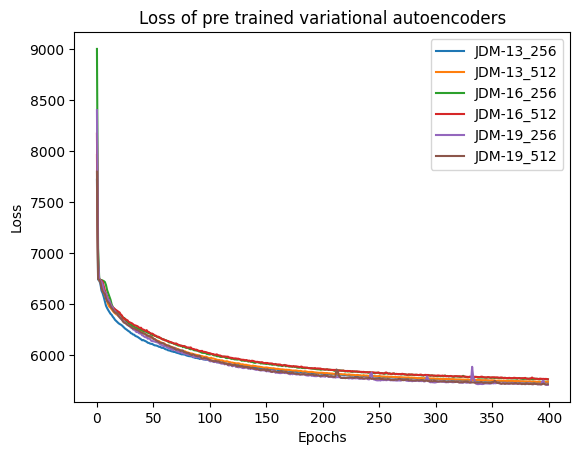

In [7]:
for name, history in histories.items():
    plt.plot(history.history["loss"], label=name.replace("_best", ""))
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss of pre trained variational autoencoders")
plt.legend()
plt.show()

In [9]:
ground_truth = imgs[np.random.randint(len(imgs), size=6)]

In [57]:
noised = ground_truth + np.random.uniform(-.3, .3, size=ground_truth.shape)

## Vector latente de 256

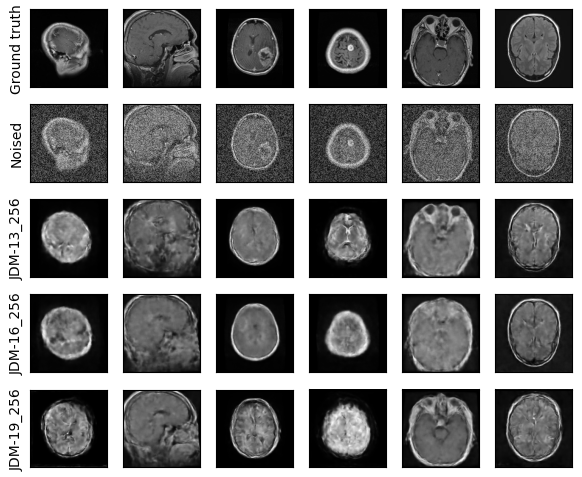

In [58]:
rows_names = ["Ground truth","Noised", "JDM-13_256", "JDM-16_256","JDM-19_256"]
plot_models = [None, None] + [JDM13_256,JDM16_256,JDM19_256] # aqui van los modelos

_, axs = plt.subplots(5, 6, figsize=(7,7), sharex=True, sharey=True)
for i, (row_name, model)  in enumerate(zip(rows_names, plot_models)):
    axs[i][0].set_ylabel(row_name, rotation=90)
    for j, (img, n_img) in enumerate(zip(ground_truth, noised)):
        axs[i][j].set_yticks([])
        axs[i][j].set_xticks([])
        if row_name == "Ground truth":
            predicted = img
        elif row_name == "Noised":
            predicted = n_img
        else:
            predicted = model([n_img[np.newaxis,:,:,:]])[0]
        axs[i][j].imshow(predicted, cmap="gray")
plt.subplots_adjust(hspace=-0.4)
plt.show()

## Vector latente de 512

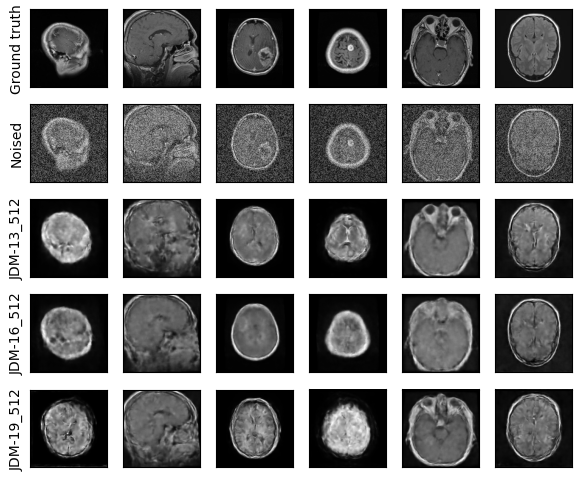

In [59]:
rows_names = ["Ground truth","Noised", "JDM-13_512", "JDM-16_512","JDM-19_512"]
plot_models = [None, None] + [JDM13_256,JDM16_256,JDM19_256] # aqui van los modelos

_, axs = plt.subplots(5, 6, figsize=(7,7), sharex=True, sharey=True)
for i, (row_name, model)  in enumerate(zip(rows_names, plot_models)):
    axs[i][0].set_ylabel(row_name, rotation=90)
    for j, (img, n_img) in enumerate(zip(ground_truth, noised)):
        axs[i][j].set_yticks([])
        axs[i][j].set_xticks([])
        if row_name == "Ground truth":
            predicted = img
        elif row_name == "Noised":
            predicted = n_img
        else:
            predicted = model([n_img[np.newaxis,:,:,:]])[0]
        axs[i][j].imshow(predicted, cmap="gray")
plt.subplots_adjust(hspace=-0.4)
plt.show()

## Cargar modelo preentrenado

In [110]:
ex = create_VAE(input_img_shape, latent_dim = 512, n_blocks=13)

In [113]:
ex.load_weights("models/JDM_weights/JDM-13_512_best.h5")

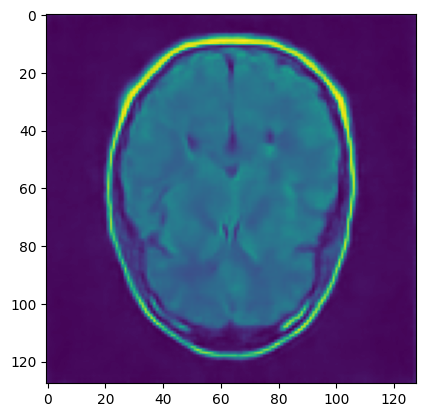

In [116]:
plt.imshow(ex(np.array([img]))[0])